<a href="https://colab.research.google.com/github/FedericoSabbadini/TalentScope_AI/blob/main/Talent_Radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Import

In [137]:
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Loading

In [138]:
# Configurazioni iniziali
DATA_PATH = "/content/fifa_players.csv"
OUTPUT_PATH = "kaggle_submissions/"
RANDOM_STATE = 3993
TRAIN_SIZE = 0.75

# Caricamento dei dati
df = pd.read_csv(DATA_PATH)

# Utility

In [139]:
def generateSubmission(myModel, submissionFile, description):
    # Read the test data
    data = pd.read_csv(DATA_PATH)
    Id, X_test= data.Id,data.drop(columns=DROPCOLUMS)
    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)

    # Use the model to make predictions
    y_test_pred = myModel.predict(X_test_imp)

    # submission file
    my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})

    if not os.path.exists(OUTPUT_PATH):
      os.mkdir(OUTPUT_PATH)

    # you could use any filename. We choose submission here
    my_submission.to_csv(OUTPUT_PATH, index=False)

    # Submit authomatically; kaggle API authentication needed
    #!kaggle competitions submit -c heart-attack-analysis-and-prediction-21 -f {OUTPUT_PATH/submissionFile} -m '{description}'

# Features Engineering

## Missing Values

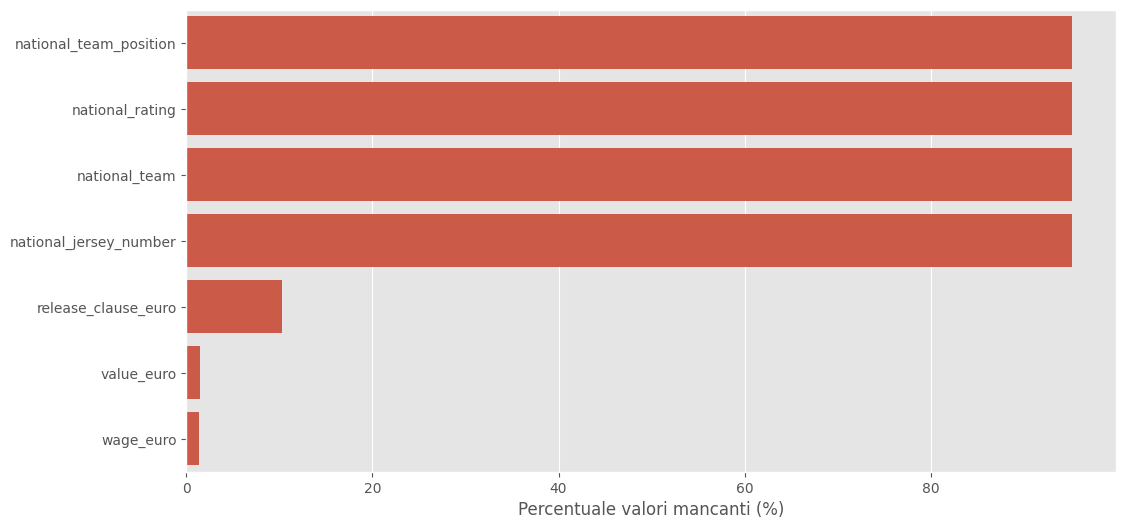

In [140]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = missing / len(df) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index)
plt.xlabel("Percentuale valori mancanti (%)")
plt.ylabel("")
plt.show()

## Features

In [141]:
df_filtered = df[
    df['potential'].notna() & df['overall_rating'].notna()
    ].copy()

features=(df_filtered.columns)
print(features)

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')


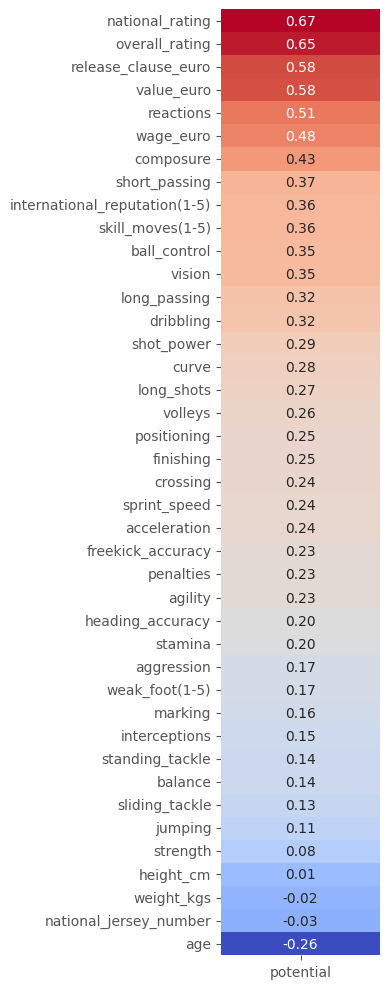

In [142]:
df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()

features = corr['potential'].drop('potential').sort_values(ascending=False).index.tolist()

plt.figure(figsize=(4, 10))  # stretto e alto
sns.heatmap(corr.loc[features, ['potential']], annot=True, cmap='coolwarm', fmt=".2f", cbar=False)

plt.tight_layout()
plt.show()

## Aggregated Features

### 1. Growth Potential Index

In [143]:
df_filtered['growth_potential_index'] = np.where(
    df_filtered['age'] <= 23,
    ((df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35) / 1.0) *
    (1 + (24 - df_filtered['age']) * 0.1 + df_filtered['international_reputation(1-5)'] * 0.02),
    np.where(
        df_filtered['age'] <= 27,
        ((df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35) / 1.0) *
        (1 + (28 - df_filtered['age']) * 0.05),
        df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35
    )
)

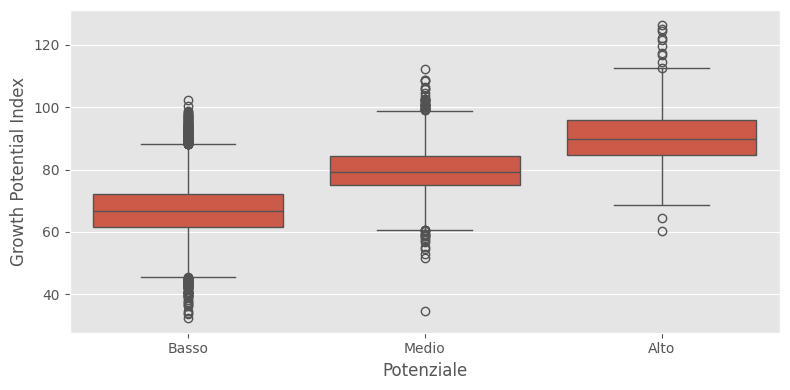

In [144]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

bins = [0, 76, 82, 100]
labels = ['Basso', 'Medio', 'Alto']
df_filtered['potential_category'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)

sns.boxplot(x='potential_category', y='growth_potential_index', data=df_filtered)
plt.xlabel('Potenziale')
plt.ylabel('Growth Potential Index')
plt.tight_layout()

### 2. Reaction Development

In [145]:
df_filtered['reaction_development'] = np.where(
    df_filtered['age'] <= 20, df_filtered['reactions'] / 53.6,
    np.where(df_filtered['age'] <= 25, df_filtered['reactions'] / 60.5,
    np.where(df_filtered['age'] <= 30, df_filtered['reactions'] / 65.3,
    df_filtered['reactions'] / 67.1))
) * 1.2

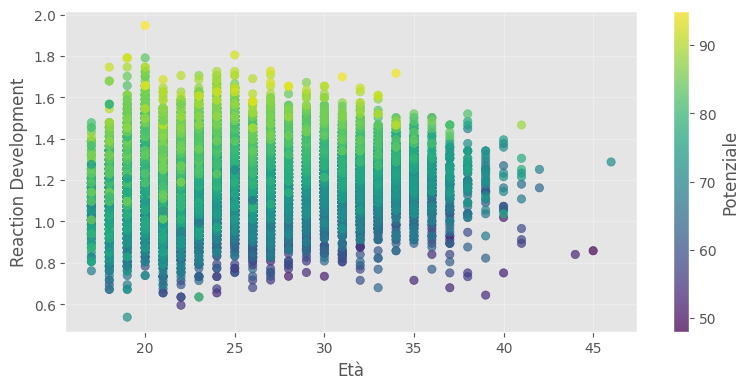

In [146]:
plt.scatter(df_filtered['age'], df_filtered['reaction_development'],
           c=df_filtered['potential'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Potenziale')
plt.xlabel('Età')
plt.ylabel('Reaction Development')
plt.grid(True, alpha=0.3)
plt.tight_layout()

### 3. Role Quality

In [147]:
df_filtered['main_position'] = df_filtered['positions'].str.split(',').str[0].str.strip()
position_groups = {
    'Attackers': ['ST', 'CF', 'LW', 'RW', 'LS', 'RS'],
    'Midfielders': ['CM', 'CAM', 'CDM', 'LM', 'RM'],
    'Defenders': ['CB', 'LB', 'RB', 'LWB', 'RWB'],
    'Goalkeepers': ['GK']
}
df_filtered['position_group'] = df_filtered['main_position'].apply(
    lambda x: next((k for k, v in position_groups.items() if x in v), 'Other')
)

# Skill per attaccanti
df_filtered['attacker_quality'] = (
    df_filtered['dribbling'] * 0.25 +
    df_filtered['finishing'] * 0.25 +
    df_filtered['acceleration'] * 0.15 +
    df_filtered['positioning'] * 0.2 +
    df_filtered['reactions'] * 0.15
) / df_filtered['age']

# Skill per centrocampisti
df_filtered['midfielder_quality'] = (
    df_filtered['short_passing'] * 0.25 +
    df_filtered['vision'] * 0.25 +
    df_filtered['ball_control'] * 0.15 +
    df_filtered['stamina'] * 0.1 +
    df_filtered['interceptions'] * 0.15 +
    df_filtered['reactions'] * 0.1
) / df_filtered['age']

# Skill per difensori
df_filtered['defender_quality'] = (
    df_filtered['standing_tackle'] * 0.25 +
    df_filtered['interceptions'] * 0.25 +
    df_filtered['marking'] * 0.25 +
    df_filtered['strength'] * 0.15 +
    df_filtered['reactions'] * 0.1
) / df_filtered['age']

# Skill per portieri
df_filtered['goalkeeper_quality'] = (
    df_filtered['reactions'] * 0.4 +
    df_filtered['composure'] * 0.3 +
    df_filtered['agility'] * 0.15 +
    df_filtered['jumping'] * 0.15
) / df_filtered['age']

In [148]:
df_filtered['role_quality'] = np.where(
    df_filtered['position_group'] == 'Attackers',
    df_filtered['attacker_quality'],
        np.where(
            df_filtered['position_group'] == 'Defenders',
            df_filtered['defender_quality'],
            np.where(
                df_filtered['position_group'] == 'Goalkeepers',
                df_filtered['goalkeeper_quality'],
                    df_filtered['midfielder_quality']  # default per 'Other'
        )
    )
)

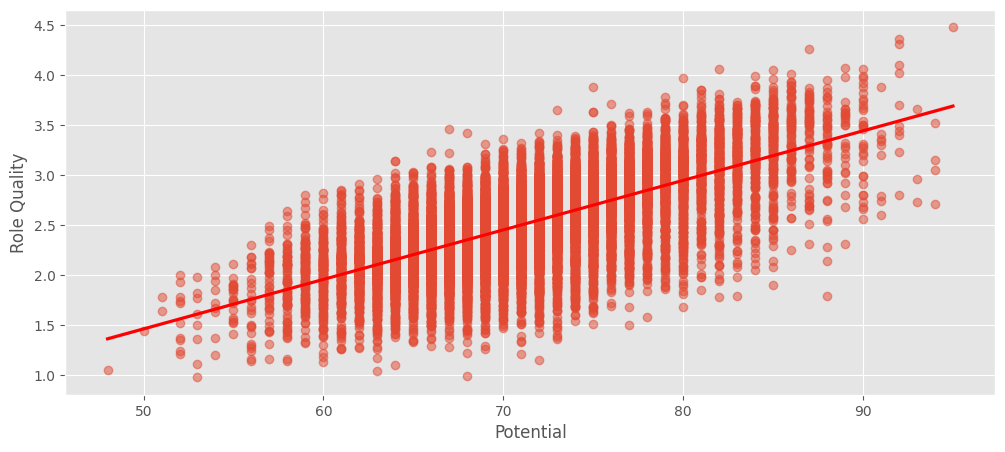

In [149]:
plt.figure(figsize=(12, 5))
sns.regplot(x='potential', y='role_quality', data=df_filtered, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Potential')
plt.ylabel('Role Quality')
plt.show()

### 4. Market Value



In [150]:
df_filtered['market_value'] = np.clip(
    np.sqrt(np.log1p(df_filtered['release_clause_euro'].fillna(df_filtered['value_euro'].fillna(0)))) / 15 *
    df_filtered['overall_rating'] / 150 *
    (1 + (28 - df_filtered['age'].clip(upper=28)) / 120) *
    (1 + df_filtered['international_reputation(1-5)'] * 0.05),
    0, 2
)

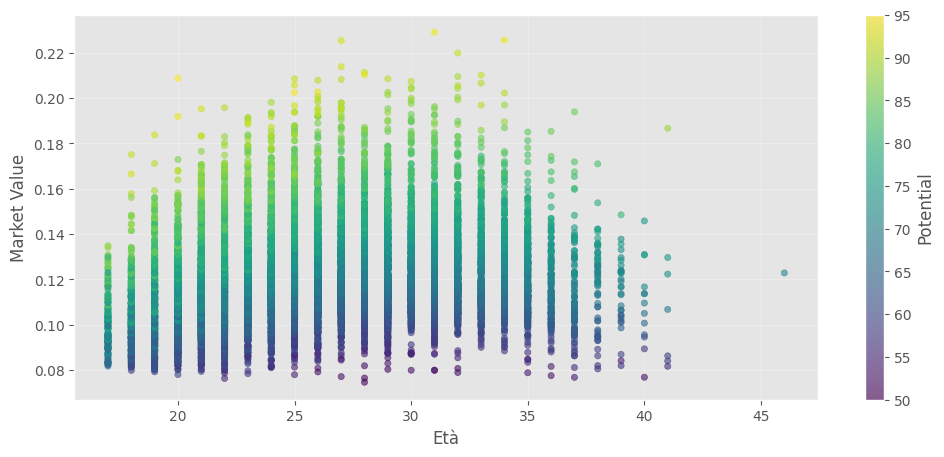

In [151]:
plt.figure(figsize=(12, 5))

df_plot = df_filtered[df_filtered['market_value'] != 0]

scatter = plt.scatter(df_plot['age'], df_plot['market_value'],
                      c=df_plot['potential'], cmap='viridis', alpha=0.6, s=20)

plt.xlabel('Età')
plt.ylabel('Market Value')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Potential')

plt.show()

In [152]:
median_value_by_overall = df_filtered.groupby('overall_rating')['value_euro'].median()

df_filtered['relative_market_value'] = df_filtered.apply(
    lambda x: x['value_euro'] / median_value_by_overall.get(x['overall_rating'], 1)
    if x['overall_rating'] in median_value_by_overall else 1, axis=1
)

### 5. Athletic Potential Index

In [153]:
df_filtered['athletic_potential_index'] = (
    df_filtered['acceleration'] * 0.15 +
    df_filtered['sprint_speed'] * 0.15 +
    df_filtered['agility'] * 0.1 +
    df_filtered['shot_power'] * 0.2 +
    df_filtered['long_shots'] * 0.15 +
    df_filtered['stamina'] * 0.15 +
    df_filtered['dribbling'] * 0.1
)

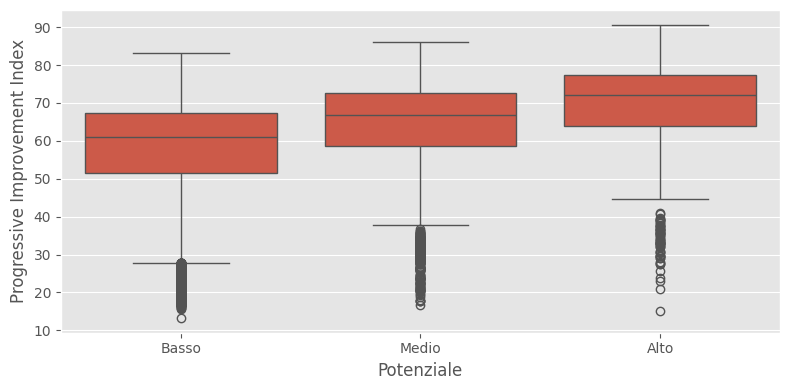

In [154]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

bins = [0, 76, 82, 100]
labels = ['Basso', 'Medio', 'Alto']
df_filtered['potential_category'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)

sns.boxplot(x='potential_category', y='athletic_potential_index', data=df_filtered)
plt.xlabel('Potenziale')
plt.ylabel('Progressive Improvement Index')
plt.tight_layout()

### 6. Skill to Price

In [179]:
# Calcolo skill_level come media ponderata
df_filtered['skill_level'] = (
    0.25 * df_filtered['ball_control'] +
    0.25 * df_filtered['composure'] +
    0.15 * df_filtered['vision'] +
    0.15 * df_filtered['short_passing'] +
    0.10 * df_filtered['agility'] +
    0.10 * df_filtered['acceleration']
)

value = df_filtered['value_euro'].clip(lower=1e5)
penalty = np.minimum(1.0, value / 500_000)

df_filtered['skill_to_price'] = (
    df_filtered['skill_level'] / (value / 1_000_000)
) * penalty

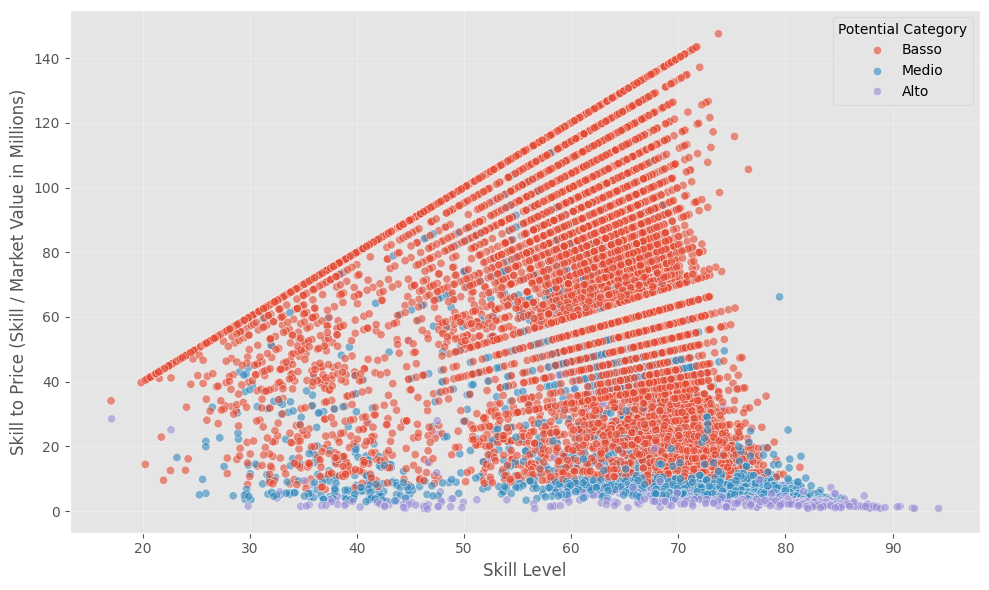

In [180]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='skill_level', y='skill_to_price', hue='potential_category', data=df_filtered, alpha=0.6)
plt.xlabel('Skill Level')
plt.ylabel('Skill to Price (Skill / Market Value in Millions)')
plt.grid(True, alpha=0.3)
plt.legend(title='Potential Category')
plt.tight_layout()
plt.show()

### 7. Overall Rating Aged

In [157]:
df_filtered['overall_rating_aged'] = np.where(
    df_filtered['age'] <= 25,
    df_filtered['overall_rating'] * (0.9 + (26 - df_filtered['age']) * 0.08),
    df_filtered['overall_rating'] * 0.9
)

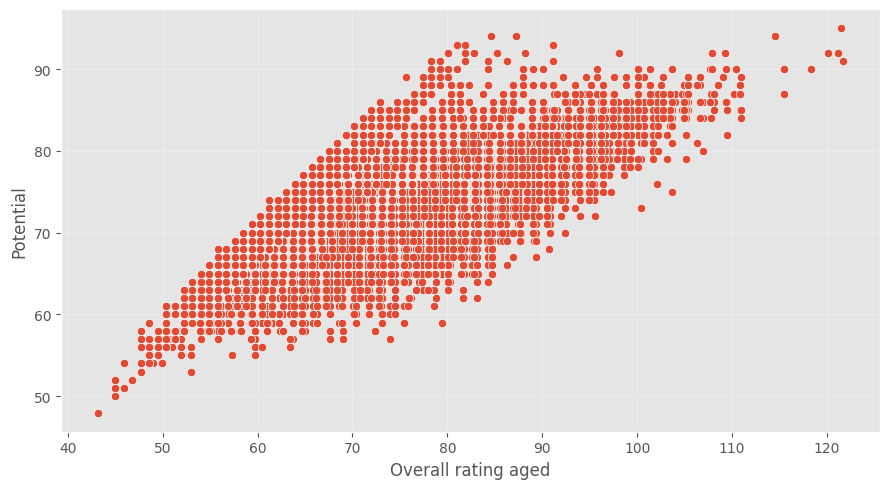

In [158]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=df_filtered, x='overall_rating_aged', y='potential')
plt.xlabel('Overall rating aged')
plt.ylabel('Potential')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

In [159]:
FEATURES = [

    'growth_potential_index',
    'reaction_development',
    'role_quality',
    'market_value',
    'relative_market_value',
    'athletic_potential_index',
    'skill_to_price',
    'overall_rating_aged',

    'potential'

    ]

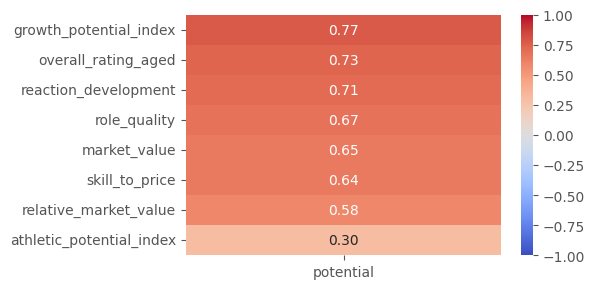

In [160]:
corr_with_potential = df_filtered[FEATURES].corr()[['potential']].abs().drop('potential').sort_values(by='potential', ascending=False)

plt.figure(figsize=(6, 3))
sns.heatmap(corr_with_potential, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.tight_layout()
plt.show()

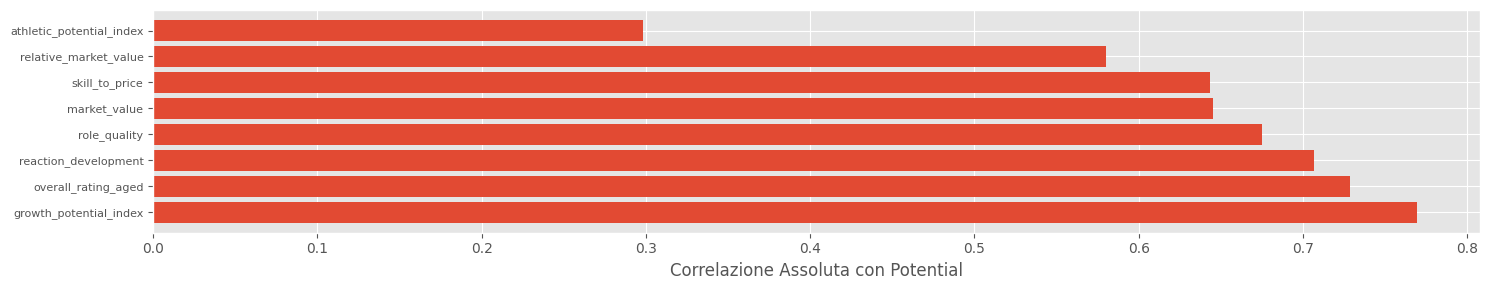

In [161]:
plt.figure(figsize=(15, 3))

corr_with_potential = df_filtered[FEATURES].corr()['potential'].abs().sort_values(ascending=False)[1:11]
plt.barh(range(len(corr_with_potential)), corr_with_potential.values)
plt.yticks(range(len(corr_with_potential)), corr_with_potential.index, fontsize=8)
plt.xlabel('Correlazione Assoluta con Potential')

plt.tight_layout()
plt.show()
FEATURES.remove('potential')

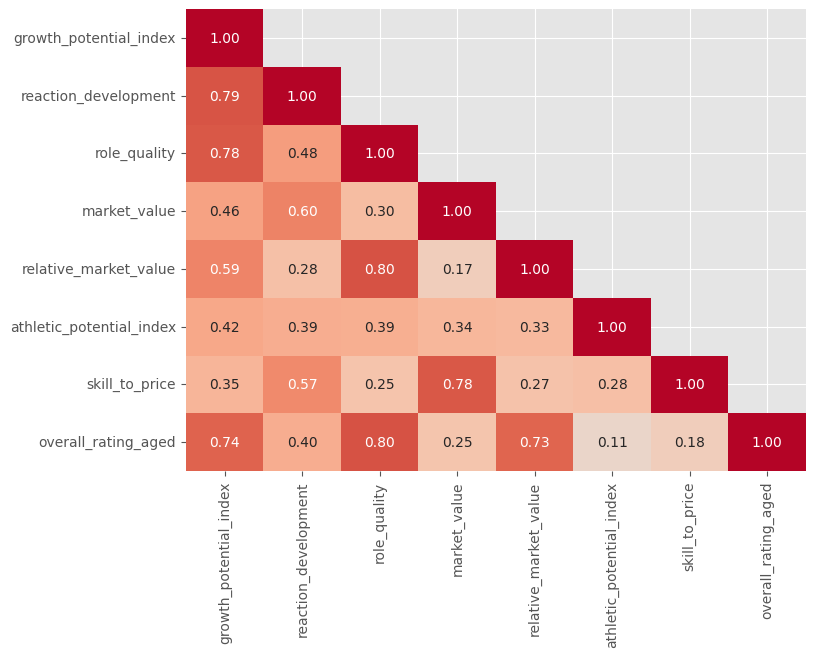

In [162]:
corr_with_potential = df_filtered[FEATURES].corr().abs()
mask = np.triu(np.ones_like(corr_with_potential, dtype=bool), k=1)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_with_potential,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt='.2f',
    cbar=False,
)
plt.show()

## Target

In [163]:
bins = [0, 76, 82, 100]
labels = [0, 1, 2]       # Basso, Medio, Alto
df_filtered['target'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)


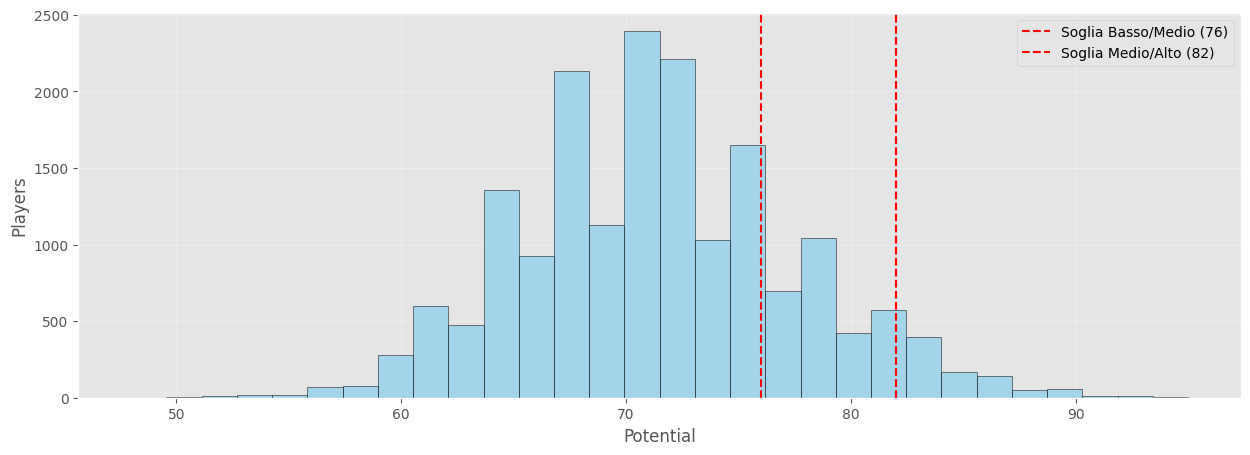

In [164]:
plt.figure(figsize=(15, 5))

plt.hist(df_filtered['potential'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(76, color='red', linestyle='--', label='Soglia Basso/Medio (76)')
plt.axvline(82, color='red', linestyle='--', label='Soglia Medio/Alto (82)')
plt.xlabel('Potential')
plt.ylabel('Players')
plt.legend()
plt.grid(True, alpha=0.3)

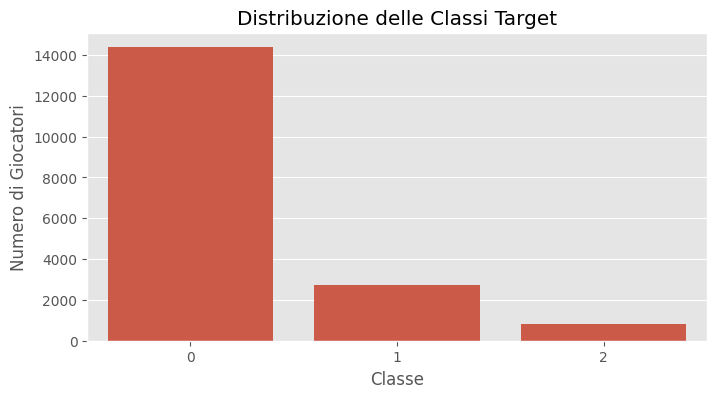

In [165]:
df_filtered['target_label'] = df_filtered['target']

sns.countplot(x='target_label', data=df_filtered)
plt.title('Distribuzione delle Classi Target')
plt.xlabel('Classe')
plt.ylabel('Numero di Giocatori')
plt.show()

# Data Processing

In [166]:
X = df_filtered[FEATURES].copy()
y = df_filtered['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [167]:
BINARY_COLS = []
print(f"Numero di colonne binarie: {len(BINARY_COLS)}")

NUMERICAL_COLS = [col for col in X.columns if X[col].dtype in ['float64', 'int64']]
print(f"Numero di colonne numeriche: {len(NUMERICAL_COLS)}")

CATEGORICAL_COLS = [col for col in X.columns if col not in NUMERICAL_COLS]
print(f"Numero di colonne categoriche: {len(CATEGORICAL_COLS)}")

Numero di colonne binarie: 0
Numero di colonne numeriche: 8
Numero di colonne categoriche: 0


In [168]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERICAL_COLS),
        ('cat', categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=False,
)

In [169]:
# Preprocessing dei dati
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model

In [170]:
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=5,
    min_samples_split=4,
    max_features=0.7,
    max_samples=0.8,
    criterion='entropy',
    bootstrap=True,
    oob_score=True,
    class_weight={0: 1.0, 1: 3, 2: 7.5},
    random_state=42,
    n_jobs=-1
)


In [171]:
# Addestramento
model.fit(X_train_processed, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 3, 2: 7.5}, criterion='entropy',
                       max_depth=12, max_features=0.7, max_samples=0.8,
                       min_samples_leaf=5, min_samples_split=4,
                       n_estimators=400, n_jobs=-1, oob_score=True,
                       random_state=42)

# Model Evaluation

In [172]:
# Predizioni
y_train_pred = model.predict(X_train_processed)
y_test_pred =  model.predict(X_test_processed)

In [173]:
# Metriche principali
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# Overfitting gap
overfitting_gap = train_acc - test_acc

In [174]:
# Output dei risultati
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print(f"Overfitting Gap: {overfitting_gap:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.9761
Test Accuracy: 0.9505
F1 Score (macro): 0.8957
Overfitting Gap: 0.0255

Confusion Matrix:
[[3500   95    0]
 [  71  577   36]
 [   0   20  190]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3595
           1       0.83      0.84      0.84       684
           2       0.84      0.90      0.87       210

    accuracy                           0.95      4489
   macro avg       0.88      0.91      0.90      4489
weighted avg       0.95      0.95      0.95      4489



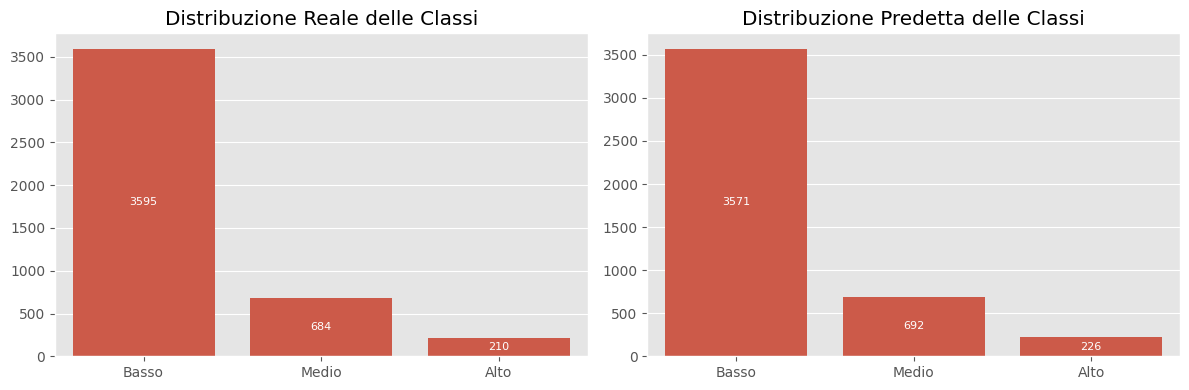

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y_test, ax=ax[0])
ax[0].set_title("Distribuzione Reale delle Classi")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['Basso', 'Medio', 'Alto'])
ax[0].set_xlabel("")
ax[0].set_ylabel("")

for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x() + p.get_width()/2, height/2, int(height),
               ha='center', va='center', color='white', fontsize=8)


sns.countplot(x=y_test_pred, ax=ax[1])
ax[1].set_title("Distribuzione Predetta delle Classi")
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['Basso', 'Medio', 'Alto'])
ax[1].set_xlabel("")
ax[1].set_ylabel("")


for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x() + p.get_width()/2, height/2, int(height),
               ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()

In [176]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_importance_df = pd.DataFrame({
    'Feature': [FEATURES[i] for i in indices],
    'Importance': [importances[i] for i in indices]
})

print("\nFeature Importance:")
print(feature_importance_df.head(20))



Feature Importance:
                    Feature  Importance
0    growth_potential_index    0.232716
1       overall_rating_aged    0.231530
2            skill_to_price    0.187334
3              market_value    0.131510
4     relative_market_value    0.103085
5      reaction_development    0.056816
6              role_quality    0.035036
7  athletic_potential_index    0.021972


# Submission

In [177]:
OUTPUT_PATH = "/content/"
my_submission = pd.DataFrame({
    "Id": id,
    "target": y_test_pred,
    "potential" : y_test
})
my_submission.to_csv(OUTPUT_PATH + "submission.csv", index=False)

In [178]:
OUTPUT_PATH = "/content/"

error_mask = y_test != y_test_pred
error_indices = y_test.index[error_mask]

df_errors = df_filtered.loc[error_indices].copy()
df_errors["true_target"] = y_test[error_mask]
df_errors["predicted_target"] = y_test_pred[error_mask]

df_errors.to_csv(OUTPUT_PATH + "submission_errors.csv", index=False)